In [1]:
import json
import pandas as pd
import glob

# Load all participant interaction files
all_interactions = []
for file_path in glob.glob("../interactions/p*.json"):
    with open(file_path, "r") as file:
        data = json.load(file)
        # Extract participant id
        participant_id = int(file_path.split("/")[-1].split(".")[0][1:])
        
        # Add participant info to each interaction
        for interaction in data["interactions"]:
            interaction["participant_id"] = participant_id
        all_interactions.extend(data["interactions"])

# Parse all interactions into a single DataFrame
df_interactions = pd.DataFrame(all_interactions)

In [2]:
import numpy as np
from Levenshtein import distance as levenshtein_distance

# Combine project_path and file_path into a new column 'path'
df_interactions["path"] = df_interactions.apply(
    lambda row: row["file_path"]
    if pd.notnull(row["file_path"])
    else (row["project_path"] if pd.notnull(row["project_path"]) else np.nan),
    axis=1,
)

# Create a new column 'task_index' based on the 'path' column
df_interactions["task_index"] = df_interactions["path"].apply(
    lambda x: 1
    if "autoencoder" in x
    else (2 if "visualization" in x else (3 if "translator" in x else None))
)

# Add columns for length of selected code and length of prompt
df_interactions["length_selected_code"] = df_interactions["selected_code"].apply(
    lambda x: len(x) if pd.notnull(x) else np.nan
)
df_interactions["length_prompt"] = df_interactions["prompt"].apply(
    lambda x: len(x) if pd.notnull(x) else np.nan
)

# Add column for Levenshtein distance between original and revised summary
df_interactions["levenshtein_distance"] = df_interactions.apply(
    lambda row: levenshtein_distance(row["original_summary"], row["revised_summary"])
    if pd.notnull(row["original_summary"]) and pd.notnull(row["revised_summary"])
    else np.nan,
    axis=1,
)

In [3]:
event_counts = (
    df_interactions.groupby(["event"])
    .size()
    .reset_index(name="event_count")
)
event_counts

,event,event_count
0,commit_declarative,227
1,commit_procedural,132
2,diff_summaries,15
3,retrieve_summary,186


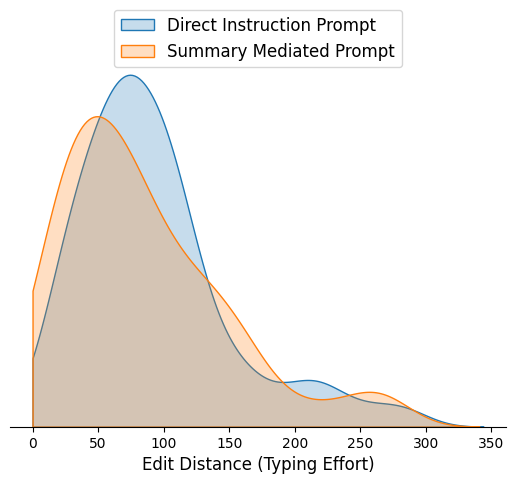

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate upper bounds at 99th percentile
prompt_upper = df_interactions["length_prompt"].quantile(0.99)
lev_upper = df_interactions["levenshtein_distance"].quantile(0.99)

# Truncate outliers using upper bounds
prompt_truncated = df_interactions["length_prompt"].clip(upper=prompt_upper)
lev_truncated = df_interactions["levenshtein_distance"].clip(upper=lev_upper)

# Plot the distributions after truncating outliers
plt.figure()
sns.kdeplot(
    prompt_truncated,
    fill=True,
    label="Direct Instruction Prompt",
    clip=(0, None),
)
sns.kdeplot(
    lev_truncated,
    fill=True,
    label="Summary Mediated Prompt", 
    clip=(0, None),
)
plt.xlabel("Edit Distance (Typing Effort)", fontsize=12)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_yticks([])
plt.gca().set_ylabel("")
plt.legend(fontsize=12, loc='center', bbox_to_anchor=(0.5, 1.05))
# plt.title("Character Count Distribution of Two Prompting Techniques", fontsize=14)
plt.savefig("./figures/type_distribution.pdf", bbox_inches='tight')
plt.show()

In [5]:
# Perform independent t-test to compare the two distributions
from scipy import stats

# Remove NaN values and top 1% from both distributions
length_prompt = df_interactions["length_prompt"].dropna()
levenshtein_distance = df_interactions["levenshtein_distance"].dropna()

# Calculate 99th percentile cutoffs
length_cutoff = length_prompt.quantile(0.99)
lev_cutoff = levenshtein_distance.quantile(0.99)

# Truncate values above 99th percentile
length_prompt = length_prompt[length_prompt <= length_cutoff]
levenshtein_distance = levenshtein_distance[levenshtein_distance <= lev_cutoff]

# Run Student's t-test (unequal sample sizes)
statistic, p_value = stats.ttest_ind(
    length_prompt,
    levenshtein_distance, 
    equal_var=False  # Use Welch's t-test for unequal sample sizes
)

print("Student's t-test results (excluding top 1%):")
print(f"t-statistic: {statistic:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant difference at 0.05 level: {'Yes' if p_value < 0.05 else 'No'}")

# Calculate basic statistics
print("\nDescriptive statistics (excluding top 1%):")
print("Average edit distance (direct instruction prompt):")
print(length_prompt.mean())
print("\nAverage edit distance (summary-mediated prompt):")
print(levenshtein_distance.mean())

Student's t-test results (excluding top 1%):
t-statistic: 1.22
p-value: 0.2248
Significant difference at 0.05 level: No

Descriptive statistics (excluding top 1%):
Average edit distance (direct instruction prompt):
89.66517857142857

Average edit distance (summary-mediated prompt):
82.18881118881119


/var/folders/cx/hz4b291d7yxgb1bfmb1ksyym0000gn/T/ipykernel_18984/41486496.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


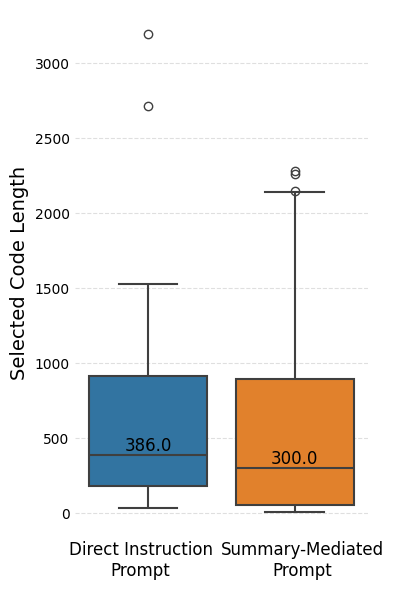

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 6))

# Prepare data
length_selected = df_interactions["length_selected_code"].dropna()
selected_cutoff = length_selected.quantile(0.99)
filtered_df = df_interactions[df_interactions["length_selected_code"] <= selected_cutoff]

# Compute medians
medians = filtered_df.groupby("event")["length_selected_code"].median()

# Color palette: matplotlib default blue and orange
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
custom_palette = [default_colors[0], default_colors[1]]

# Boxplot
ax = sns.boxplot(
    data=filtered_df,
    x="event",
    y="length_selected_code",
    order=["commit_procedural", "commit_declarative"],
    palette=custom_palette,
    showfliers=True,
    linewidth=1.5
)

# Annotate medians
for i, event in enumerate(["commit_procedural", "commit_declarative"]):
    median = medians[event]
    ax.text(i, median, f'{median:.1f}', ha='center', va='bottom', fontsize=12, color='black')

# Axis labels
plt.xticks(
    [-0.05, 1.05],
    ["Direct Instruction\nPrompt", "Summary-Mediated\nPrompt"],
    fontsize=12
)
plt.ylabel("Selected Code Length", fontsize=14)
plt.gca().set_xlabel("")

# Clean up visual style
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='both', length=0)  # Remove tick lines
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("./figures/selected_length_boxplot.pdf", bbox_inches='tight')
plt.show()


In [7]:
# Perform Mann-Whitney U test analysis on commit events
direct_commits = df_interactions[df_interactions["event"] == "commit_procedural"]["length_selected_code"].dropna()
summary_commits = df_interactions[df_interactions["event"] == "commit_declarative"]["length_selected_code"].dropna()

# Conduct Mann-Whitney U test
stat, p_value = stats.mannwhitneyu(direct_commits, summary_commits, alternative='two-sided')

print("Mann-Whitney U test results for selected code length:")
print(f"statistic: {stat:.3f}")
print(f"p-value: {p_value:.3f}")
print(f"Significant difference at 0.05 level: {'Yes' if p_value < 0.05 else 'No'}")

# Calculate percentage difference in medians
median_diff_pct = ((summary_commits.median() - direct_commits.median()) / direct_commits.median()) * 100

print(f"\nSummary mediated median is {median_diff_pct:.1f}% larger than direct instruction")

Mann-Whitney U test results for selected code length:
statistic: 15507.000
p-value: 0.321
Significant difference at 0.05 level: No

Summary mediated median is -17.9% larger than direct instruction


In [8]:
# Group by participant ID, task index, and name, and pivot event counts
df_events = df_interactions.groupby(['participant_id', 'task_index', 'event']).size().unstack(fill_value=0)

# Calculate means for other metrics
df_metrics = df_interactions.groupby(['participant_id', 'task_index']).agg({
    'length_prompt': 'mean',
    'levenshtein_distance': 'mean',
    'length_selected_code': 'mean'
})

# Combine event counts and metrics
df_summary = pd.concat([df_events, df_metrics], axis=1)

# Rename columns for clarity
df_summary = df_summary.rename(columns={
    'length_prompt': 'avg_prompt_length', 
    'levenshtein_distance': 'avg_levenshtein_distance',
    'length_selected_code': 'avg_length_selected_code'
}).reset_index()

df_summary.to_csv("./data/summary.csv", index=False)

In [9]:
df_experience = pd.read_csv("./data/experience.txt", sep="\t")
df_cognitive_load = pd.read_csv("./data/cognitive_load.txt", sep="\t")

merged_df = pd.merge(df_summary, df_experience, left_on='participant_id', right_on='Participant ID', how='left').drop('Participant ID', axis=1)
merged_df = pd.merge(merged_df, df_cognitive_load, 
                    left_on=['participant_id', 'task_index'],
                    right_on=['Participant ID', 'Task ID'],
                    how='left').drop(['Participant ID', 'Task ID'], axis=1)

skill_mapping = {
    'Very Skilled': 3,
    'Familiar with': 2, 
    'Learned but unfamiliar with': 1,
    'Never used': 0
}

skill_columns = ['TensorFlow', 'D3.js', 'Chrome Extension']
for col in skill_columns:
    merged_df[col] = merged_df[col].map(skill_mapping)

# Add technical familiarity column based on task index
merged_df['technical_familiarity'] = merged_df.apply(
    lambda row: row['TensorFlow'] if row['task_index'] == 1 
    else row['D3.js'] if row['task_index'] == 2
    else row['Chrome Extension'], axis=1
)

# Calculate total commits and percentages
merged_df['llm_commits'] = merged_df['commit_declarative'] + merged_df['commit_procedural']
merged_df['declarative%'] = (merged_df['commit_declarative'] / merged_df['llm_commits'] * 100).round(2)  
merged_df['procedural%'] = (merged_df['commit_procedural'] / merged_df['llm_commits'] * 100).round(2)

merged_df = merged_df.fillna(0)

In [10]:
# Calculate Spearman correlations and p-values between skill columns and other metrics
familiarity_columns = ['technical_familiarity']
exclude_columns = ['TensorFlow', 'D3.js', 'Chrome Extension', 'participant_id', 'task_index']
other_columns = [col for col in merged_df.columns if col not in familiarity_columns + exclude_columns]

# Normalize each metric by task_index
normalized_df = merged_df.copy()
for col in other_columns:
    normalized_df[col] = normalized_df.groupby('task_index')[col].transform(lambda x: x / x.mean())

correlation_matrix = pd.DataFrame()
pvalue_matrix = pd.DataFrame()

for skill in familiarity_columns:
    correlations = []
    pvalues = []
    for col in other_columns:
        corr, p = stats.spearmanr(merged_df[skill], normalized_df[col])
        correlations.append(corr)
        pvalues.append(p)
    correlation_matrix[skill] = correlations
    pvalue_matrix[skill] = pvalues

correlation_matrix.index = other_columns
pvalue_matrix.index = other_columns

print("Spearman correlation matrix between technical familiarity and other metrics:")
print(correlation_matrix)
print("\nP-value matrix:")
print(pvalue_matrix)

Spearman correlation matrix between technical familiarity and other metrics:
                          technical_familiarity
commit_declarative                    -0.002912
commit_procedural                     -0.085904
diff_summaries                         0.077766
retrieve_summary                      -0.152103
avg_prompt_length                     -0.024410
avg_levenshtein_distance              -0.070753
avg_length_selected_code               0.057058
Mental Demand                         -0.260767
Physical Demand                       -0.102103
Temporal Demand                       -0.161256
Own Performance                       -0.127191
Effort                                -0.208682
Frustration Level                      0.047004
Understand Effort                     -0.139973
Editing Effort                         0.026293
llm_commits                           -0.120753
declarative%                           0.053766
procedural%                           -0.087811

P-value ma